
**Generative Adversarial Networks**



In [ ]:
!pip install gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.2 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26534 sha256=178ec6fa3417ae1d8b1b91b6fdf1595e5d66d32da83c3d0833ccfb565c80d91a
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm

%matplotlib inline

In [ ]:
CUDA = True

device = torch.device("cuda:0" if CUDA else "cpu")

In [ ]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Auxiliary Modules

In [ ]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

# 2) GAN Training Structure

Complete the following class to define the GAN training structure.

In [ ]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments: \n
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch. \n
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`. \n
  `generator`: The generator. \n
  `discriminator`: The discriminator. The last layer is a LINEAR layer. \n
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode


    self.opt_G = torch.optim.Adam(self.generator.parameters() , G_lr)
    self.opt_D = torch.optim.Adam(self.discriminator.parameters() ,D_lr)
    self.loss_func = nn.BCEWithLogitsLoss()

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """

    noise = self.noise_generator(n)
    fake_samples = self.generator(noise)

    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """

    _ , x_fake = self.generate_samples(n)
    logits = self.discriminator(x_fake)
    target = torch.ones(logits.shape[0] , 1).to(device)
    if self.G_loss_mode == 'logD':


      loss = self.loss_func(logits , target)

    elif self.G_loss_mode == 'log(1-D)':


      loss = self.loss_func((logits + 1 ) , target)
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')

    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """

    _ , x_fake = self.generate_samples(x_real.shape[0])
    x_fake.detach()


    logits_real = self.discriminator(x_real)
    logits_fake = self.discriminator(x_fake)
    target = torch.ones(logits_real.shape[0], 1).to(device)
    real_loss = self.loss_func(logits_real , target)
    fake_loss = self.loss_func(logits_fake , (1-target))
    loss = real_loss + fake_loss

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times, verbose=True):
    """
    This function iterates over `train_dataloader` and trains
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)
      for _ in range(D_update_times):

        pass
        self.generator.eval()
        self.discriminator.train()
        self.discriminator.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        pass


      for _ in range(G_update_times):

        pass
        self.generator.train()
        self.discriminator.eval()
        self.generator.zero_grad()
        G_loss , _ = self.G_step(x.shape[0])
        G_loss.backward()
        self.opt_G.step()
        pass

      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if verbose and batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    if verbose:
        print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss

  def test(self, verbose=True):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)


        pass
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)

        pass
        self.generator.train()
        self.discriminator.eval()
        G_loss , _ = self.G_step(x.shape[0])

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]


    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    if verbose:
      print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1, verbose=True):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    !gpustat
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times, verbose)
        self.test(verbose)
        self.visualization_helper_fn(self)
        if epoch == 1:
          !gpustat


---

# 3) Part 1 - 2D Toy Dataset

In the first part, we will learn density of toy datasets to examine GAN training.

## 3.1) Helper functions
These are functions used in visulization.

In [ ]:
def toy2d_density_plot(samples, title, ax=None):
  """
  This function plots the distribution of `samples`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))
  print (samples.shape)
  samples = samples.detach().cpu().numpy()
  sns.kdeplot(x= samples[:, 0], y= samples[:, 1], shade=True, ax=ax)
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [ ]:
def toy2d_decision_boundary_plot(samples, labels, title, ax=None):
  """
  This function plots regions corresponding to each label value. Can be used to
  understand the decision boundary of `discriminator`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()

  sns.scatterplot(
      x=samples[:, 0],
      y=samples[:, 1],
      hue=labels,
      legend='brief',
      marker='.',
      ax=ax
      )
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [ ]:
def toy2d_visulization_helper_fn(trainer: GANTrainer):
  """
  Used to visualize generator's distribution and
  discriminator's decision boundary.
  """
  rows = 1
  cols = 2
  fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(3 * cols, 3 * rows))

  _, fake_samples = trainer.generate_samples(10000)
  print (fake_samples.shape)
  random_samples = (torch.rand((10000, 2)) - .5) * 3 * R
  random_samples = random_samples.to(device)
  with torch.no_grad():
    disc_labels = torch.sigmoid(trainer.discriminator(random_samples))[:, 0]

  toy2d_density_plot(fake_samples, 'generator distribution', axs[0][0])
  toy2d_decision_boundary_plot(random_samples, disc_labels, 'discriminator decision boundary', axs[0][1])

  plt.show()

## 3.2) Defining Toy Datasets

In [ ]:
class Toy2dCircularGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes` gaussians on a circle with 'r' radius.
  """
  def __init__(self, r=10, std_dev=1, n_modes=20, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes

    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples,))
    theta = 2 * np.pi / n_modes * self.mode_ids
    mu = self.r * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu

  def __getitem__(self, i):
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

In [ ]:
class Toy2dGridGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes^2` gaussians on a grid with '2r' width and height.
  """
  def __init__(self, r=1, std_dev=1, n_modes=5, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    assert n_modes >= 2

    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples, 2))
    mu = self.mode_ids * (2 * self.r / (self.n_modes - 1)) - self.r
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu

  def __getitem__(self, i):
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

## 3.3) Dataset Loading


You can load either `Toy2dCircularGaussiansDataset` or `Toy2dGridGaussiansDataset` to play with it; but the question at the end of this part is for the `Toy2dGridGaussiansDataset` dataset.

In [ ]:
# parameters of toy dataset
TRAIN_SIZE = 60000
TEST_SIZE = 10000
R = 1

# ############### To use `Toy2dCircularGaussiansDataset` ############### #
# N_MODES = 8
# STD_DEV = 25e-3
# toy2d_train_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
# toy2d_test_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

# ################# To use `Toy2dGridGaussiansDataset` ################# #
N_MODES = 4
STD_DEV = 1e-4
toy2d_train_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
toy2d_test_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

torch.Size([10000, 2])


<ipython-input-21-58a5d7880755>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x= samples[:, 0], y= samples[:, 1], shade=True, ax=ax)


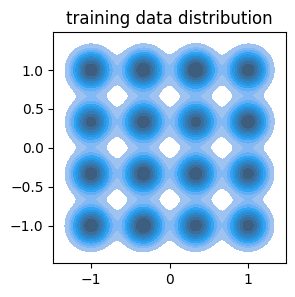

In [ ]:
# Ploting dataset distribution to see it :)

toy2d_density_plot(toy2d_train_dataset[:10000][0], 'training data distribution')

## 3.4) Defining Models

In [ ]:
# Generator part

toy2d_noise_generator = NoiseGenerator(( 1 , 32 , 32))

toy2d_generator = nn.Sequential(nn.Flatten() , nn.Linear(1024 , 500) , nn.Tanh(), nn.Linear(500 , 250) , nn.Tanh() , nn.Linear(250 , 2))

# Discriminator part

toy2d_discriminator = nn.Sequential(nn.Linear(2 , 250) , nn.Tanh() , nn.Linear(250 , 500) , nn.Tanh()  , nn.Linear(500 , 1))

toy2d_generator = toy2d_generator.to(device)
toy2d_discriminator = toy2d_discriminator.to(device)

print(toy2d_generator)
print(toy2d_discriminator)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=500, bias=True)
  (2): Tanh()
  (3): Linear(in_features=500, out_features=250, bias=True)
  (4): Tanh()
  (5): Linear(in_features=250, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=250, bias=True)
  (1): Tanh()
  (2): Linear(in_features=250, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=1, bias=True)
)


## 3.5) Train

### 3.5.1) Batching Data

In [ ]:
BATCH_SIZE = 1024

toy2d_dataloader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

toy2d_train_dataloader = torch.utils.data.DataLoader(toy2d_train_dataset, **toy2d_dataloader_kwargs)
toy2d_test_dataloader = torch.utils.data.DataLoader(toy2d_test_dataset, **toy2d_dataloader_kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 3.5.2) Run

In [ ]:
LOG_INTERVAL = 100

TOY2D_G_LEARNING_RATE = 0.001
TOY2D_D_LEARNING_RATE = 0.001
G_LOSS_MODE = 'log(1-D)'

toy2d_trainer = GANTrainer(toy2d_train_dataloader, toy2d_test_dataloader,
                           toy2d_noise_generator, toy2d_generator, toy2d_discriminator,
                           TOY2D_G_LEARNING_RATE, TOY2D_D_LEARNING_RATE,
                           toy2d_visulization_helper_fn, G_LOSS_MODE)

9cc427aef2cd  Wed Oct 11 03:48:36 2023  525.105.17
[0] Tesla T4 | 68°C,   0 % |   307 / 15360 MB |


  0%|          | 0/59 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>    self._shutdown_workers()self._shutdown_workers()

Traceback (most recent call last):
Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3

Train | Epoch: 1 [0/60416]		D-Loss: 0.850965	G-Loss: 2.345419
====> Train | Epoch: 1 	 | 	Average D-loss: 0.2879 	 | 	Average G-loss: 2.0671


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

 

====> Test | Average D-loss: 0.7312 	 | 	Average G-loss: 1.6964
torch.Size([10000, 2])
torch.Size([10000, 2])


<ipython-input-21-58a5d7880755>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x= samples[:, 0], y= samples[:, 1], shade=True, ax=ax)


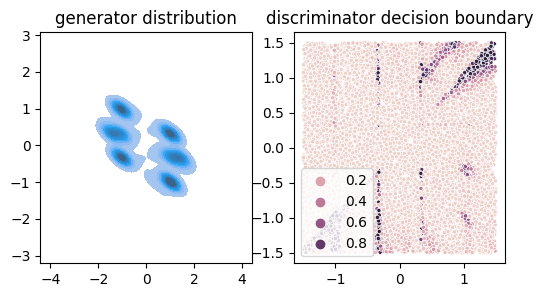

9cc427aef2cd  Wed Oct 11 03:49:13 2023  525.105.17
[0] Tesla T4 | 69°C,   0 % |   309 / 15360 MB |


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 2 [0/60416]		D-Loss: 0.299389	G-Loss: 1.919373
====> Train | Epoch: 2 	 | 	Average D-loss: 0.3812 	 | 	Average G-loss: 1.5154


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: self._shutdown_workers()    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
  File "/usr/lib/python3.10/multiprocessing/process.py"

====> Test | Average D-loss: 0.8852 	 | 	Average G-loss: 1.2570
torch.Size([10000, 2])
torch.Size([10000, 2])


<ipython-input-21-58a5d7880755>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x= samples[:, 0], y= samples[:, 1], shade=True, ax=ax)


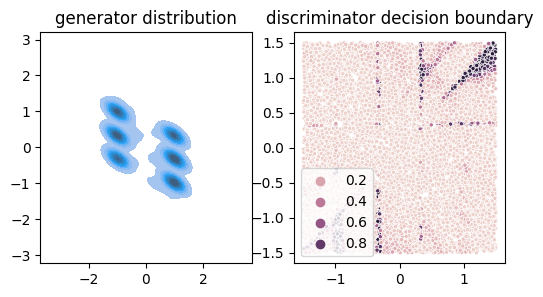

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 3 [0/60416]		D-Loss: 0.519458	G-Loss: 1.720288


KeyboardInterrupt: ignored

In [ ]:

toy2d_trainer.run(n_epoch=20, G_update_times=10, D_update_times=30, verbose=True)


### 3.5.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 12 to 15)

torch.Size([10000, 2])
torch.Size([10000, 2])


<ipython-input-21-58a5d7880755>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x= samples[:, 0], y= samples[:, 1], shade=True, ax=ax)


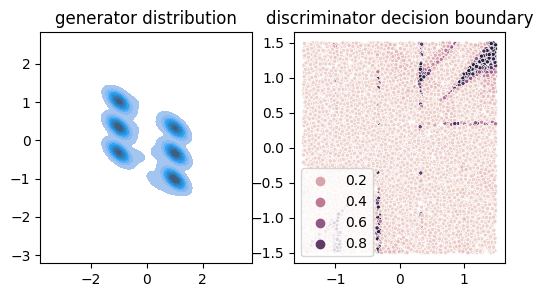

In [ ]:
toy2d_visulization_helper_fn(toy2d_trainer)

# 4) Part 2 - MNIST

In the second part, we will learn to generate MNIST like samples.

## 4.1) Helper functions
These are functions used in visulization.

In [ ]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result

In [ ]:
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  print (image_batch.shape)
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows) # set default size of plots  TODO float(folan)?

  for i in range(image_batch.shape[0]):
      plt.subplot(int(rows), int(cols), i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

In [ ]:
def mnist_visulization_helper_fn(trainer: GANTrainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

In [ ]:
def show_interpolations(trainer:GANTrainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

## 4.2) Dataset Loading

In [ ]:
# Get MNIST dataloader

mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1, # to make pixel values between [-1, 1]
                                    #  lambda img: torch.transpose(img, 1, 2)
                                     ])
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)

print(len(mnist_train_dataset))

100%|██████████| 9912422/9912422 [00:00<00:00, 155957848.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39393721.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51293036.44it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3451182.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000


torch.Size([30, 1, 28, 28])


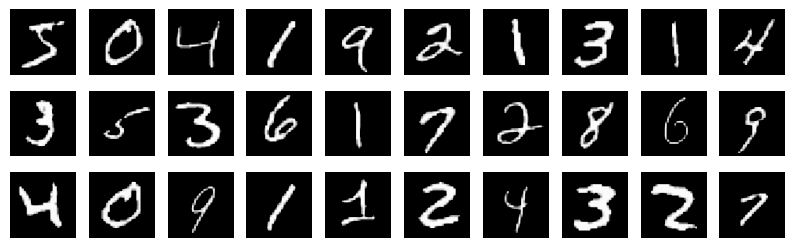

In [ ]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

## 4.3) Defining Models




In [ ]:
# Generator part

mnist_noise_generator = NoiseGenerator(( 1 , 10 , 10))

mnist_generator = nn.Sequential(nn.Flatten() ,
        nn.Linear(100 , 1024) , nn.LeakyReLU(True),
        nn.Linear(1024, 7*7*128),
        nn.LeakyReLU(inplace=True),
        Reshape((128, 7, 7)),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
)

mnist_discriminator = nn.Sequential(Reshape( (1, 28, 28)),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(1024, 1024),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(1024, 1)
)

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=100, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Linear(in_features=1024, out_features=6272, bias=True)
  (4): LeakyReLU(negative_slope=0.01, inplace=True)
  (5): Reshape()
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.01, inplace=True)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): Tanh()
)
Sequential(
  (0): Reshape()
  (1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.01, inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

## 4.4) Train

### 4.4.1) Batching Data

you can use `train_sampler` and `test_sampler` to test your model on smaller subset of dataset; but, the final report must be on the whole dataset.

In [ ]:
BATCH_SIZE = 256

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE,
    'pin_memory': True,
    'num_workers': 4,
}

# ############### To use complete dataset ############### #
train_sampler = None
test_sampler = None
mnist_dataloader_kwargs['shuffle'] = True
# ####################################################### #

# ############### To use subsample of dataset ############### #
# train_sampler = torch.utils.data.RandomSampler(mnist_train_dataset, replacement=True, num_samples=10000)
# test_sampler = torch.utils.data.RandomSampler(mnist_test_dataset, replacement=True, num_samples=2000)
# mnist_dataloader_kwargs['shuffle'] = False
# ########################################################### #

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler=train_sampler, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler=test_sampler, **mnist_dataloader_kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 4.4.2) Run

In [ ]:
LOG_INTERVAL = 50

MNIST_G_LEARNING_RATE = 0.001
MNIST_D_LEARNING_RATE = 0.005
G_LOSS_MODE = 'log(1-D)'

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

9cc427aef2cd  Wed Oct 11 03:53:37 2023  525.105.17
[0] Tesla T4 | 67°C,   0 % |   309 / 15360 MB |


  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 1 [0/60160]		D-Loss: 1.379125	G-Loss: 0.000000
Train | Epoch: 1 [12800/60160]		D-Loss: 0.148621	G-Loss: 20.977299
Train | Epoch: 1 [25600/60160]		D-Loss: 0.084618	G-Loss: 11.022679
Train | Epoch: 1 [38400/60160]		D-Loss: 0.178221	G-Loss: 9.732437
Train | Epoch: 1 [51200/60160]		D-Loss: 0.068417	G-Loss: 6.232413
====> Train | Epoch: 1 	 | 	Average D-loss: 0.2289 	 | 	Average G-loss: 10.9405
====> Test | Average D-loss: 0.1160 	 | 	Average G-loss: 3.5107
torch.Size([30, 1, 28, 28])


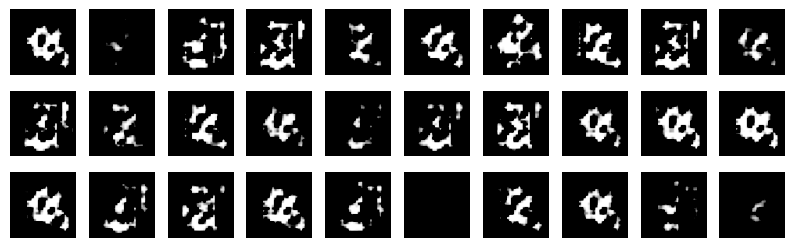

9cc427aef2cd  Wed Oct 11 03:54:15 2023  525.105.17
[0] Tesla T4 | 71°C,   0 % |   639 / 15360 MB |


  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 2 [0/60160]		D-Loss: 0.114935	G-Loss: 7.050129
Train | Epoch: 2 [12800/60160]		D-Loss: 0.063701	G-Loss: 6.988622
Train | Epoch: 2 [25600/60160]		D-Loss: 0.075825	G-Loss: 7.412303
Train | Epoch: 2 [38400/60160]		D-Loss: 0.065445	G-Loss: 9.663128
Train | Epoch: 2 [51200/60160]		D-Loss: 0.052039	G-Loss: 9.908714
====> Train | Epoch: 2 	 | 	Average D-loss: 0.0905 	 | 	Average G-loss: 8.3184
====> Test | Average D-loss: 0.0904 	 | 	Average G-loss: 7.9432
torch.Size([30, 1, 28, 28])


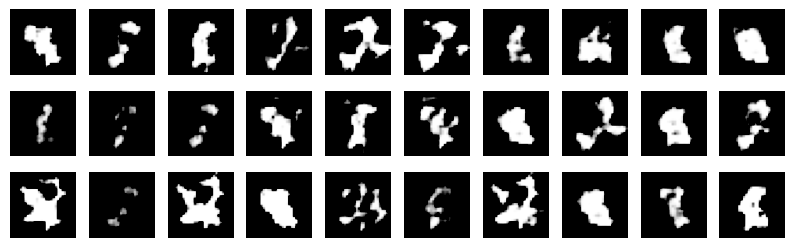

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 3 [0/60160]		D-Loss: 0.042004	G-Loss: 8.184614
Train | Epoch: 3 [12800/60160]		D-Loss: 0.117221	G-Loss: 5.761860
Train | Epoch: 3 [25600/60160]		D-Loss: 0.020638	G-Loss: 8.405075
Train | Epoch: 3 [38400/60160]		D-Loss: 0.207911	G-Loss: 5.027867
Train | Epoch: 3 [51200/60160]		D-Loss: 0.065949	G-Loss: 6.564985
====> Train | Epoch: 3 	 | 	Average D-loss: 0.0796 	 | 	Average G-loss: 7.0745
====> Test | Average D-loss: 0.0785 	 | 	Average G-loss: 5.6901
torch.Size([30, 1, 28, 28])


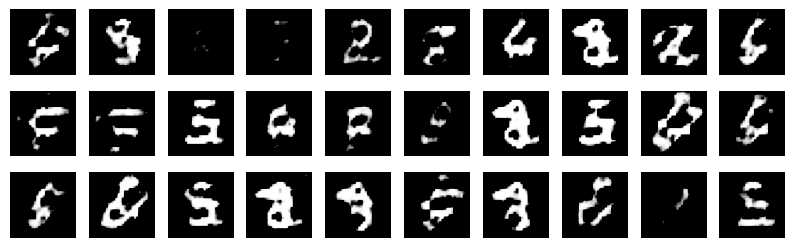

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 4 [0/60160]		D-Loss: 0.086584	G-Loss: 5.273268
Train | Epoch: 4 [12800/60160]		D-Loss: 0.101908	G-Loss: 5.876176
Train | Epoch: 4 [25600/60160]		D-Loss: 0.061323	G-Loss: 5.605060
Train | Epoch: 4 [38400/60160]		D-Loss: 0.096298	G-Loss: 5.130350
Train | Epoch: 4 [51200/60160]		D-Loss: 0.070485	G-Loss: 5.716474
====> Train | Epoch: 4 	 | 	Average D-loss: 0.0847 	 | 	Average G-loss: 6.3533
====> Test | Average D-loss: 0.1107 	 | 	Average G-loss: 5.5390
torch.Size([30, 1, 28, 28])


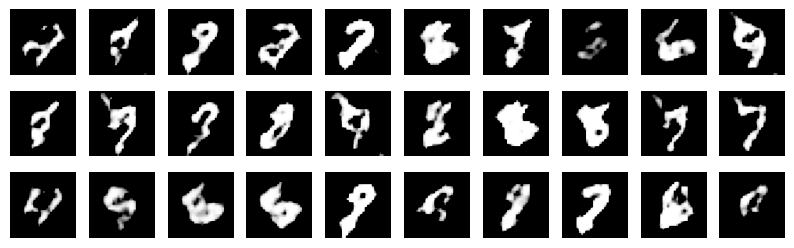

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 5 [0/60160]		D-Loss: 0.129781	G-Loss: 6.137549
Train | Epoch: 5 [12800/60160]		D-Loss: 0.176370	G-Loss: 4.458869
Train | Epoch: 5 [25600/60160]		D-Loss: 0.103733	G-Loss: 5.963248
Train | Epoch: 5 [38400/60160]		D-Loss: 0.114934	G-Loss: 4.657700
Train | Epoch: 5 [51200/60160]		D-Loss: 0.177298	G-Loss: 6.014042
====> Train | Epoch: 5 	 | 	Average D-loss: 0.1173 	 | 	Average G-loss: 5.0550
====> Test | Average D-loss: 0.1168 	 | 	Average G-loss: 5.6784
torch.Size([30, 1, 28, 28])


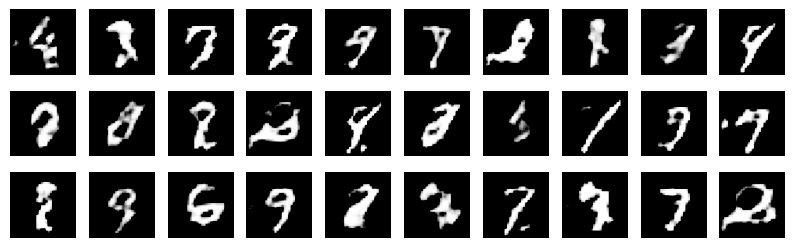

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 6 [0/60160]		D-Loss: 0.091301	G-Loss: 6.959410
Train | Epoch: 6 [12800/60160]		D-Loss: 0.151848	G-Loss: 4.011477
Train | Epoch: 6 [25600/60160]		D-Loss: 0.158135	G-Loss: 4.231790
Train | Epoch: 6 [38400/60160]		D-Loss: 0.086803	G-Loss: 4.028385
Train | Epoch: 6 [51200/60160]		D-Loss: 0.244387	G-Loss: 4.041151
====> Train | Epoch: 6 	 | 	Average D-loss: 0.1818 	 | 	Average G-loss: 4.2326
====> Test | Average D-loss: 0.2066 	 | 	Average G-loss: 4.0508
torch.Size([30, 1, 28, 28])


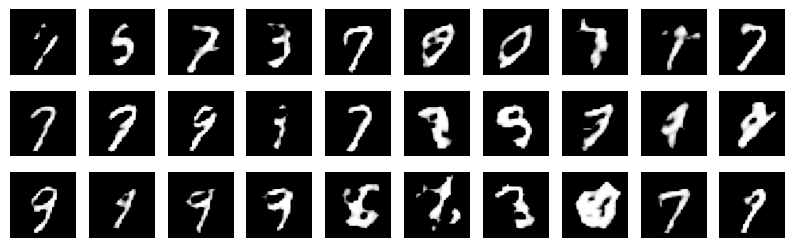

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 7 [0/60160]		D-Loss: 0.170105	G-Loss: 3.407810
Train | Epoch: 7 [12800/60160]		D-Loss: 0.235224	G-Loss: 5.270583
Train | Epoch: 7 [25600/60160]		D-Loss: 0.179414	G-Loss: 3.327171
Train | Epoch: 7 [38400/60160]		D-Loss: 0.284764	G-Loss: 3.644468
Train | Epoch: 7 [51200/60160]		D-Loss: 0.249612	G-Loss: 2.698436
====> Train | Epoch: 7 	 | 	Average D-loss: 0.2539 	 | 	Average G-loss: 3.2578
====> Test | Average D-loss: 0.2908 	 | 	Average G-loss: 3.4213
torch.Size([30, 1, 28, 28])


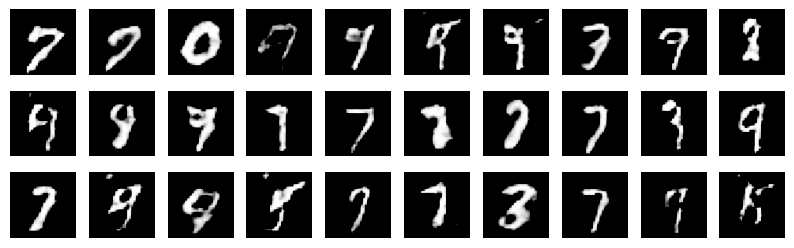

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 8 [0/60160]		D-Loss: 0.333032	G-Loss: 3.490722
Train | Epoch: 8 [12800/60160]		D-Loss: 0.255604	G-Loss: 2.887019
Train | Epoch: 8 [25600/60160]		D-Loss: 0.251166	G-Loss: 2.917628
Train | Epoch: 8 [38400/60160]		D-Loss: 0.184909	G-Loss: 3.254865
Train | Epoch: 8 [51200/60160]		D-Loss: 0.190901	G-Loss: 3.648966
====> Train | Epoch: 8 	 | 	Average D-loss: 0.2824 	 | 	Average G-loss: 3.0454
====> Test | Average D-loss: 0.2589 	 | 	Average G-loss: 2.1953
torch.Size([30, 1, 28, 28])


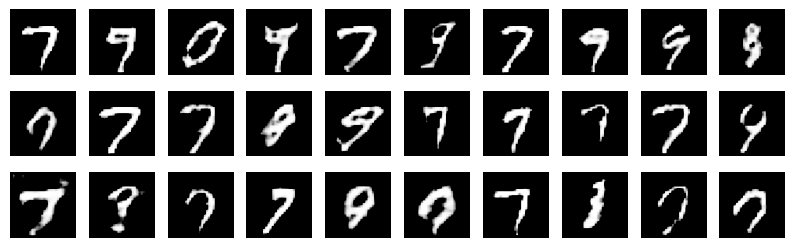

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 9 [0/60160]		D-Loss: 0.268723	G-Loss: 2.497799
Train | Epoch: 9 [12800/60160]		D-Loss: 0.266154	G-Loss: 3.183154
Train | Epoch: 9 [25600/60160]		D-Loss: 0.173809	G-Loss: 4.009162
Train | Epoch: 9 [38400/60160]		D-Loss: 0.406352	G-Loss: 2.928156
Train | Epoch: 9 [51200/60160]		D-Loss: 0.403142	G-Loss: 3.517580
====> Train | Epoch: 9 	 | 	Average D-loss: 0.2853 	 | 	Average G-loss: 2.7722
====> Test | Average D-loss: 0.2558 	 | 	Average G-loss: 2.2624
torch.Size([30, 1, 28, 28])


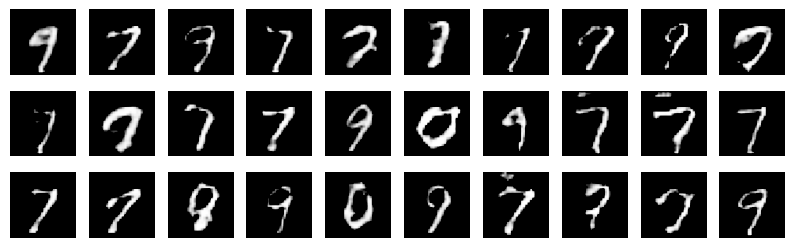

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 10 [0/60160]		D-Loss: 0.234865	G-Loss: 3.188631
Train | Epoch: 10 [12800/60160]		D-Loss: 0.353345	G-Loss: 2.649035
Train | Epoch: 10 [25600/60160]		D-Loss: 0.272799	G-Loss: 2.469469
Train | Epoch: 10 [38400/60160]		D-Loss: 0.398595	G-Loss: 2.204268
Train | Epoch: 10 [51200/60160]		D-Loss: 0.315087	G-Loss: 2.592096
====> Train | Epoch: 10 	 | 	Average D-loss: 0.2767 	 | 	Average G-loss: 2.8922
====> Test | Average D-loss: 0.2437 	 | 	Average G-loss: 2.4147
torch.Size([30, 1, 28, 28])


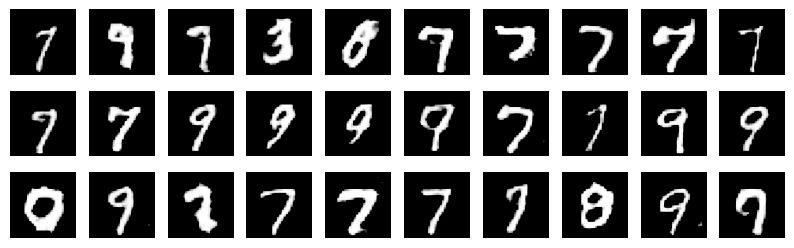

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 11 [0/60160]		D-Loss: 0.191839	G-Loss: 2.934933
Train | Epoch: 11 [12800/60160]		D-Loss: 0.343785	G-Loss: 1.841945
Train | Epoch: 11 [25600/60160]		D-Loss: 0.232229	G-Loss: 2.291146
Train | Epoch: 11 [38400/60160]		D-Loss: 0.233830	G-Loss: 2.859741
Train | Epoch: 11 [51200/60160]		D-Loss: 0.425945	G-Loss: 2.651346
====> Train | Epoch: 11 	 | 	Average D-loss: 0.2812 	 | 	Average G-loss: 2.7791


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>    Traceback (most recent call last):

self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
            self._shutdown_workers()if w.is_alive():self._shutdown_workers()


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/loc

====> Test | Average D-loss: 0.3730 	 | 	Average G-loss: 2.1068
torch.Size([30, 1, 28, 28])


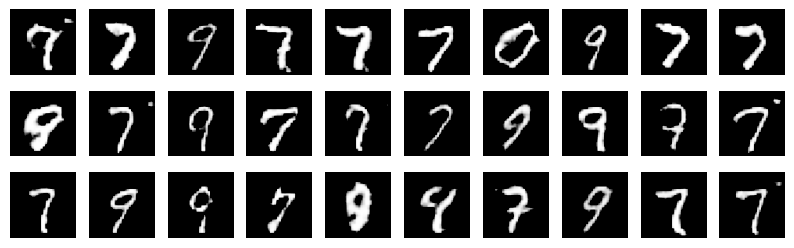

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 12 [0/60160]		D-Loss: 0.339917	G-Loss: 3.210095
Train | Epoch: 12 [12800/60160]		D-Loss: 0.273190	G-Loss: 2.600239
Train | Epoch: 12 [25600/60160]		D-Loss: 0.262225	G-Loss: 3.240041
Train | Epoch: 12 [38400/60160]		D-Loss: 0.315234	G-Loss: 2.528352
Train | Epoch: 12 [51200/60160]		D-Loss: 0.201299	G-Loss: 4.383134
====> Train | Epoch: 12 	 | 	Average D-loss: 0.2673 	 | 	Average G-loss: 2.8477
====> Test | Average D-loss: 0.2748 	 | 	Average G-loss: 3.2879
torch.Size([30, 1, 28, 28])


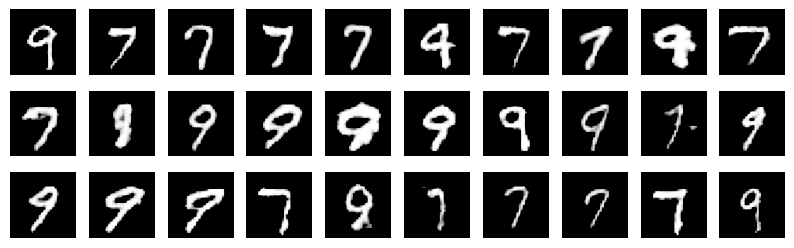

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 13 [0/60160]		D-Loss: 0.250803	G-Loss: 3.416964
Train | Epoch: 13 [12800/60160]		D-Loss: 0.194732	G-Loss: 3.347116
Train | Epoch: 13 [25600/60160]		D-Loss: 0.478658	G-Loss: 2.288105
Train | Epoch: 13 [38400/60160]		D-Loss: 0.258312	G-Loss: 3.568099
Train | Epoch: 13 [51200/60160]		D-Loss: 0.346880	G-Loss: 1.881786
====> Train | Epoch: 13 	 | 	Average D-loss: 0.3225 	 | 	Average G-loss: 2.8041
====> Test | Average D-loss: 0.3213 	 | 	Average G-loss: 2.6834
torch.Size([30, 1, 28, 28])


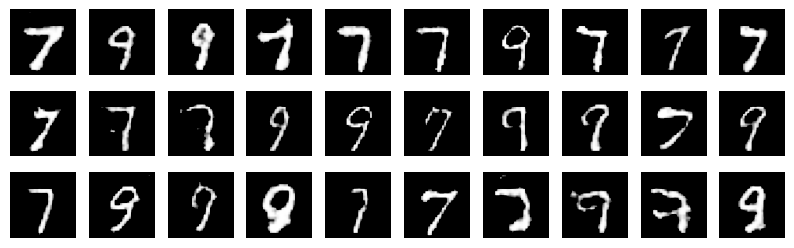

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 14 [0/60160]		D-Loss: 0.390236	G-Loss: 1.966060
Train | Epoch: 14 [12800/60160]		D-Loss: 0.263299	G-Loss: 3.382031
Train | Epoch: 14 [25600/60160]		D-Loss: 0.281151	G-Loss: 2.530800
Train | Epoch: 14 [38400/60160]		D-Loss: 0.201673	G-Loss: 2.123216
Train | Epoch: 14 [51200/60160]		D-Loss: 0.326273	G-Loss: 3.199922
====> Train | Epoch: 14 	 | 	Average D-loss: 0.2930 	 | 	Average G-loss: 2.6291
====> Test | Average D-loss: 0.2831 	 | 	Average G-loss: 1.9377
torch.Size([30, 1, 28, 28])


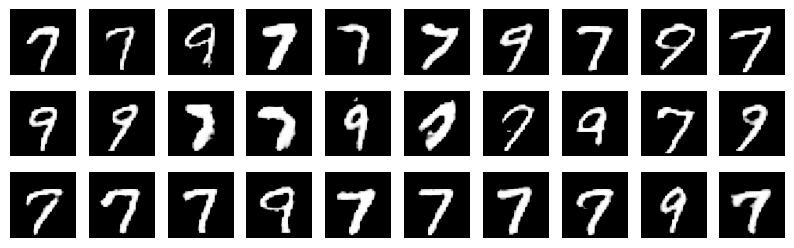

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 15 [0/60160]		D-Loss: 0.376478	G-Loss: 1.605273
Train | Epoch: 15 [12800/60160]		D-Loss: 0.336764	G-Loss: 1.941601
Train | Epoch: 15 [25600/60160]		D-Loss: 0.246320	G-Loss: 1.986760
Train | Epoch: 15 [38400/60160]		D-Loss: 0.216236	G-Loss: 2.797156
Train | Epoch: 15 [51200/60160]		D-Loss: 0.353704	G-Loss: 3.121375
====> Train | Epoch: 15 	 | 	Average D-loss: 0.2734 	 | 	Average G-loss: 2.6065


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>    

self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
        self._shutdown_workers()if w.is_alive():Traceback (most recent call last

====> Test | Average D-loss: 0.3595 	 | 	Average G-loss: 1.7277
torch.Size([30, 1, 28, 28])


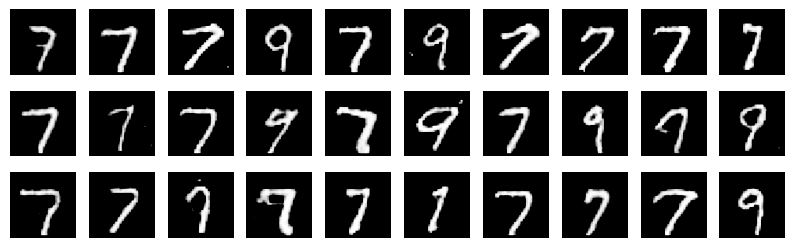

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 16 [0/60160]		D-Loss: 0.350918	G-Loss: 2.040509
Train | Epoch: 16 [12800/60160]		D-Loss: 0.299896	G-Loss: 2.309478
Train | Epoch: 16 [25600/60160]		D-Loss: 0.211224	G-Loss: 1.944441
Train | Epoch: 16 [38400/60160]		D-Loss: 0.272890	G-Loss: 2.601226
Train | Epoch: 16 [51200/60160]		D-Loss: 0.332464	G-Loss: 1.412139
====> Train | Epoch: 16 	 | 	Average D-loss: 0.3067 	 | 	Average G-loss: 2.4353
====> Test | Average D-loss: 0.3113 	 | 	Average G-loss: 2.6017
torch.Size([30, 1, 28, 28])


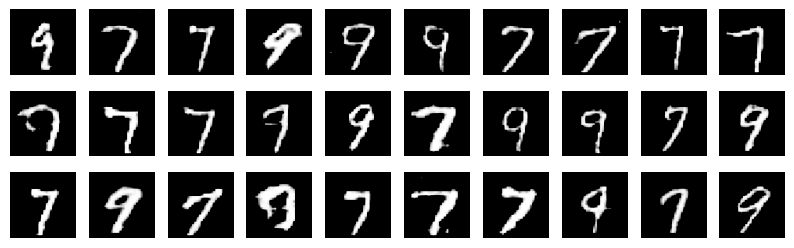

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 17 [0/60160]		D-Loss: 0.294702	G-Loss: 2.963113
Train | Epoch: 17 [12800/60160]		D-Loss: 0.219637	G-Loss: 2.898079
Train | Epoch: 17 [25600/60160]		D-Loss: 0.147994	G-Loss: 3.136273
Train | Epoch: 17 [38400/60160]		D-Loss: 0.211361	G-Loss: 2.357107
Train | Epoch: 17 [51200/60160]		D-Loss: 0.318773	G-Loss: 2.383373
====> Train | Epoch: 17 	 | 	Average D-loss: 0.2558 	 | 	Average G-loss: 2.8488
====> Test | Average D-loss: 0.2803 	 | 	Average G-loss: 3.0000
torch.Size([30, 1, 28, 28])


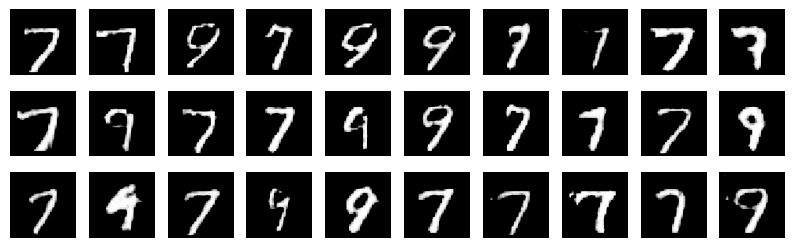

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 18 [0/60160]		D-Loss: 0.282437	G-Loss: 3.450887
Train | Epoch: 18 [12800/60160]		D-Loss: 0.359965	G-Loss: 2.706434
Train | Epoch: 18 [25600/60160]		D-Loss: 0.220654	G-Loss: 2.374997
Train | Epoch: 18 [38400/60160]		D-Loss: 0.252078	G-Loss: 2.956408
Train | Epoch: 18 [51200/60160]		D-Loss: 0.187933	G-Loss: 4.256904
====> Train | Epoch: 18 	 | 	Average D-loss: 0.2456 	 | 	Average G-loss: 3.0740
====> Test | Average D-loss: 0.2389 	 | 	Average G-loss: 2.6357
torch.Size([30, 1, 28, 28])


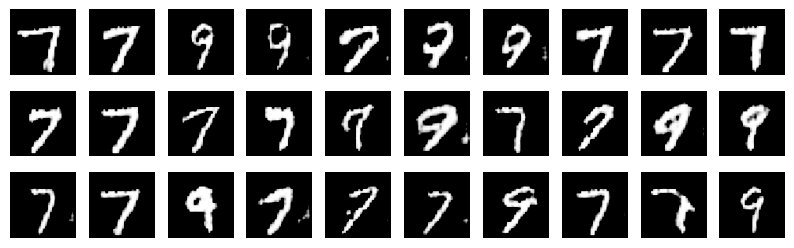

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 19 [0/60160]		D-Loss: 0.223332	G-Loss: 3.391521
Train | Epoch: 19 [12800/60160]		D-Loss: 0.317440	G-Loss: 3.745795
Train | Epoch: 19 [25600/60160]		D-Loss: 0.213990	G-Loss: 2.301147
Train | Epoch: 19 [38400/60160]		D-Loss: 0.277027	G-Loss: 3.164839
Train | Epoch: 19 [51200/60160]		D-Loss: 0.229862	G-Loss: 3.117682
====> Train | Epoch: 19 	 | 	Average D-loss: 0.2378 	 | 	Average G-loss: 3.0754
====> Test | Average D-loss: 0.2493 	 | 	Average G-loss: 2.6294
torch.Size([30, 1, 28, 28])


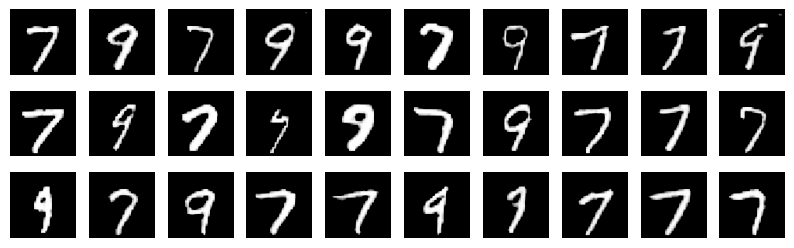

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 20 [0/60160]		D-Loss: 0.211068	G-Loss: 2.669825
Train | Epoch: 20 [12800/60160]		D-Loss: 0.253600	G-Loss: 2.229949
Train | Epoch: 20 [25600/60160]		D-Loss: 0.256272	G-Loss: 2.551922
Train | Epoch: 20 [38400/60160]		D-Loss: 0.312126	G-Loss: 2.483398
Train | Epoch: 20 [51200/60160]		D-Loss: 0.219150	G-Loss: 3.449741
====> Train | Epoch: 20 	 | 	Average D-loss: 0.2385 	 | 	Average G-loss: 3.0375
====> Test | Average D-loss: 0.7963 	 | 	Average G-loss: 5.0487
torch.Size([30, 1, 28, 28])


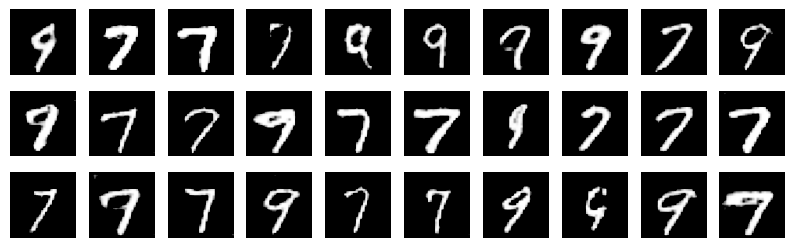

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 21 [0/60160]		D-Loss: 0.952166	G-Loss: 4.664875
Train | Epoch: 21 [12800/60160]		D-Loss: 0.366891	G-Loss: 1.670787
Train | Epoch: 21 [25600/60160]		D-Loss: 0.173515	G-Loss: 3.078600
Train | Epoch: 21 [38400/60160]		D-Loss: 0.229552	G-Loss: 2.884233
Train | Epoch: 21 [51200/60160]		D-Loss: 0.253771	G-Loss: 2.797640
====> Train | Epoch: 21 	 | 	Average D-loss: 0.2482 	 | 	Average G-loss: 2.9360
====> Test | Average D-loss: 0.3483 	 | 	Average G-loss: 2.2953
torch.Size([30, 1, 28, 28])


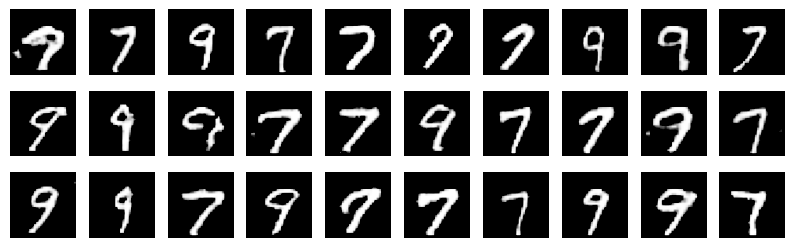

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 22 [0/60160]		D-Loss: 0.348592	G-Loss: 4.051949
Train | Epoch: 22 [12800/60160]		D-Loss: 0.174768	G-Loss: 2.548850
Train | Epoch: 22 [25600/60160]		D-Loss: 0.220015	G-Loss: 3.454425
Train | Epoch: 22 [38400/60160]		D-Loss: 0.280210	G-Loss: 2.195656
Train | Epoch: 22 [51200/60160]		D-Loss: 0.239873	G-Loss: 3.386102
====> Train | Epoch: 22 	 | 	Average D-loss: 0.2531 	 | 	Average G-loss: 2.7502
====> Test | Average D-loss: 0.2435 	 | 	Average G-loss: 2.5740
torch.Size([30, 1, 28, 28])


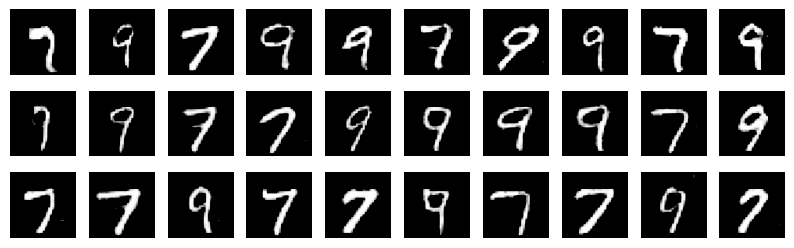

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 23 [0/60160]		D-Loss: 0.191873	G-Loss: 2.013403
Train | Epoch: 23 [12800/60160]		D-Loss: 0.197602	G-Loss: 2.761957
Train | Epoch: 23 [25600/60160]		D-Loss: 0.265758	G-Loss: 2.448776
Train | Epoch: 23 [38400/60160]		D-Loss: 0.271697	G-Loss: 2.916030
Train | Epoch: 23 [51200/60160]		D-Loss: 0.198623	G-Loss: 3.283026
====> Train | Epoch: 23 	 | 	Average D-loss: 0.2405 	 | 	Average G-loss: 2.7587
====> Test | Average D-loss: 0.2958 	 | 	Average G-loss: 2.8870
torch.Size([30, 1, 28, 28])


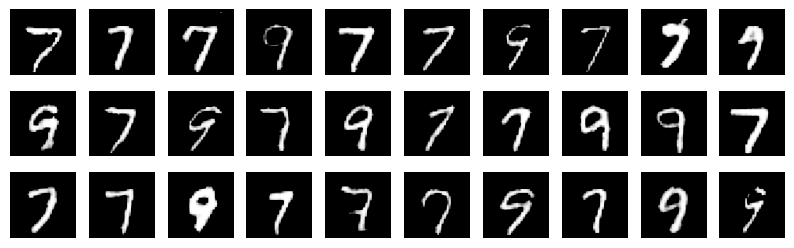

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 24 [0/60160]		D-Loss: 0.317580	G-Loss: 2.962341
Train | Epoch: 24 [12800/60160]		D-Loss: 0.238129	G-Loss: 2.849095
Train | Epoch: 24 [25600/60160]		D-Loss: 0.181717	G-Loss: 3.699240
Train | Epoch: 24 [38400/60160]		D-Loss: 0.229101	G-Loss: 3.266161
Train | Epoch: 24 [51200/60160]		D-Loss: 0.216330	G-Loss: 3.493972
====> Train | Epoch: 24 	 | 	Average D-loss: 0.2305 	 | 	Average G-loss: 2.9431
====> Test | Average D-loss: 0.2603 	 | 	Average G-loss: 3.7583
torch.Size([30, 1, 28, 28])


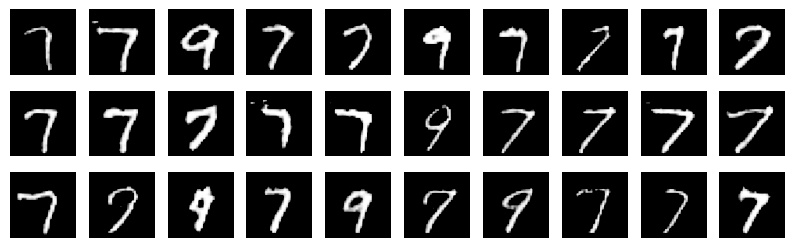

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 25 [0/60160]		D-Loss: 0.216264	G-Loss: 3.761014
Train | Epoch: 25 [12800/60160]		D-Loss: 0.130376	G-Loss: 4.010961
Train | Epoch: 25 [25600/60160]		D-Loss: 0.365334	G-Loss: 3.149632
Train | Epoch: 25 [38400/60160]		D-Loss: 0.214687	G-Loss: 2.086773
Train | Epoch: 25 [51200/60160]		D-Loss: 0.183533	G-Loss: 2.616319
====> Train | Epoch: 25 	 | 	Average D-loss: 0.2233 	 | 	Average G-loss: 3.0111
====> Test | Average D-loss: 0.2088 	 | 	Average G-loss: 2.5126
torch.Size([30, 1, 28, 28])


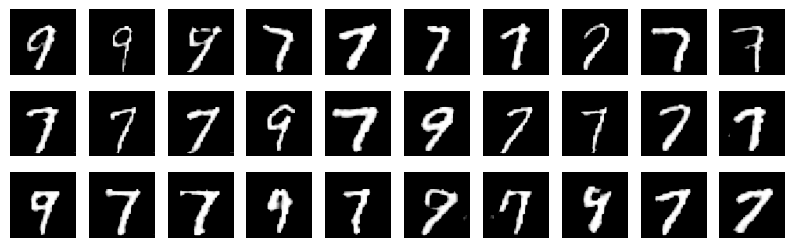

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 26 [0/60160]		D-Loss: 0.165388	G-Loss: 3.338377
Train | Epoch: 26 [12800/60160]		D-Loss: 0.330192	G-Loss: 6.489730
Train | Epoch: 26 [25600/60160]		D-Loss: 0.205515	G-Loss: 2.316354
Train | Epoch: 26 [38400/60160]		D-Loss: 0.272433	G-Loss: 2.497072
Train | Epoch: 26 [51200/60160]		D-Loss: 0.396994	G-Loss: 2.399058
====> Train | Epoch: 26 	 | 	Average D-loss: 0.2085 	 | 	Average G-loss: 3.1619
====> Test | Average D-loss: 0.2553 	 | 	Average G-loss: 3.6296
torch.Size([30, 1, 28, 28])


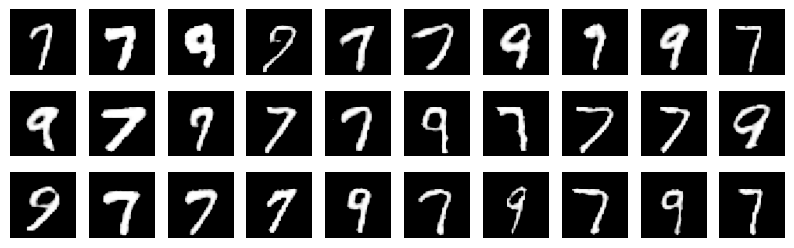

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 27 [0/60160]		D-Loss: 0.148789	G-Loss: 4.116964
Train | Epoch: 27 [12800/60160]		D-Loss: 0.228236	G-Loss: 2.403300
Train | Epoch: 27 [25600/60160]		D-Loss: 0.254247	G-Loss: 2.577930
Train | Epoch: 27 [38400/60160]		D-Loss: 0.241532	G-Loss: 2.594905
Train | Epoch: 27 [51200/60160]		D-Loss: 0.233024	G-Loss: 1.766483
====> Train | Epoch: 27 	 | 	Average D-loss: 0.2329 	 | 	Average G-loss: 2.8502
====> Test | Average D-loss: 0.4019 	 | 	Average G-loss: 4.2940
torch.Size([30, 1, 28, 28])


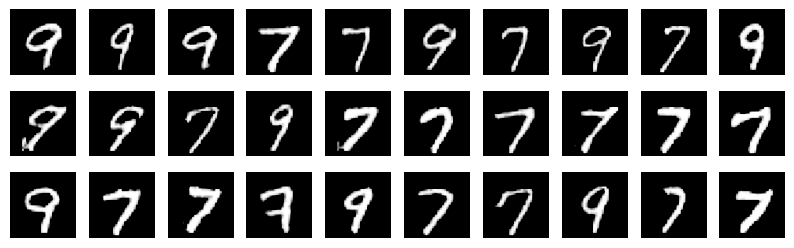

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 28 [0/60160]		D-Loss: 0.407823	G-Loss: 4.123558
Train | Epoch: 28 [12800/60160]		D-Loss: 0.151433	G-Loss: 3.482079
Train | Epoch: 28 [25600/60160]		D-Loss: 0.203617	G-Loss: 3.886511
Train | Epoch: 28 [38400/60160]		D-Loss: 0.213748	G-Loss: 3.033526
Train | Epoch: 28 [51200/60160]		D-Loss: 0.229273	G-Loss: 3.364339
====> Train | Epoch: 28 	 | 	Average D-loss: 0.2145 	 | 	Average G-loss: 2.9837
====> Test | Average D-loss: 0.1983 	 | 	Average G-loss: 3.4181
torch.Size([30, 1, 28, 28])


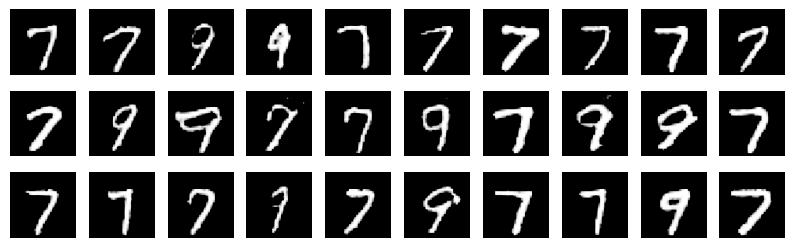

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 29 [0/60160]		D-Loss: 0.110442	G-Loss: 3.862912
Train | Epoch: 29 [12800/60160]		D-Loss: 0.244912	G-Loss: 2.993567
Train | Epoch: 29 [25600/60160]		D-Loss: 0.132076	G-Loss: 3.924826
Train | Epoch: 29 [38400/60160]		D-Loss: 0.218072	G-Loss: 3.730527
Train | Epoch: 29 [51200/60160]		D-Loss: 0.190193	G-Loss: 4.346606
====> Train | Epoch: 29 	 | 	Average D-loss: 0.2206 	 | 	Average G-loss: 3.1397
====> Test | Average D-loss: 0.4173 	 | 	Average G-loss: 1.7195
torch.Size([30, 1, 28, 28])


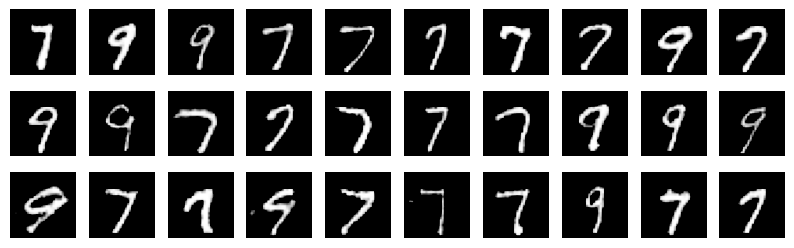

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 30 [0/60160]		D-Loss: 0.381990	G-Loss: 3.202808
Train | Epoch: 30 [12800/60160]		D-Loss: 0.128045	G-Loss: 4.020370
Train | Epoch: 30 [25600/60160]		D-Loss: 0.237663	G-Loss: 3.480268
Train | Epoch: 30 [38400/60160]		D-Loss: 0.278429	G-Loss: 6.277334
Train | Epoch: 30 [51200/60160]		D-Loss: 0.195654	G-Loss: 2.954710
====> Train | Epoch: 30 	 | 	Average D-loss: 0.1857 	 | 	Average G-loss: 3.8357


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    

self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/pyth

====> Test | Average D-loss: 0.2518 	 | 	Average G-loss: 3.0794
torch.Size([30, 1, 28, 28])


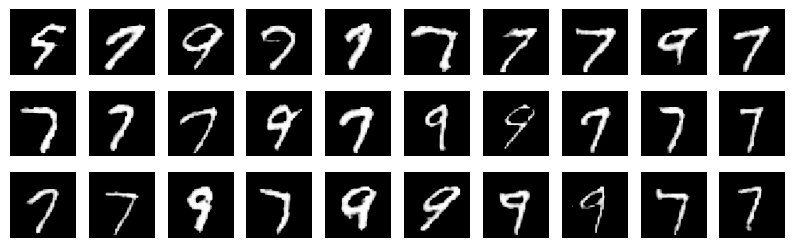

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 31 [0/60160]		D-Loss: 0.116790	G-Loss: 3.103030
Train | Epoch: 31 [12800/60160]		D-Loss: 0.198446	G-Loss: 2.731305
Train | Epoch: 31 [25600/60160]		D-Loss: 0.236978	G-Loss: 2.613640
Train | Epoch: 31 [38400/60160]		D-Loss: 0.250794	G-Loss: 2.768344
Train | Epoch: 31 [51200/60160]		D-Loss: 0.204065	G-Loss: 2.792565
====> Train | Epoch: 31 	 | 	Average D-loss: 0.2097 	 | 	Average G-loss: 3.2314
====> Test | Average D-loss: 0.3490 	 | 	Average G-loss: 1.7918
torch.Size([30, 1, 28, 28])


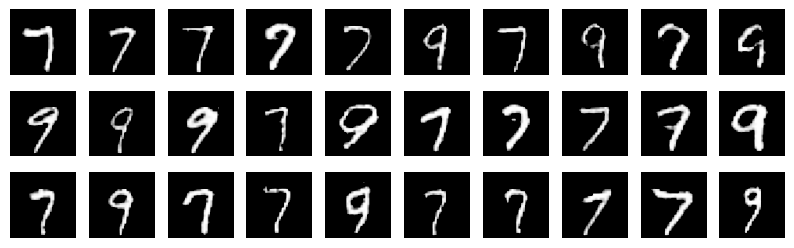

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 32 [0/60160]		D-Loss: 0.250272	G-Loss: 1.760802
Train | Epoch: 32 [12800/60160]		D-Loss: 0.187516	G-Loss: 1.886128
Train | Epoch: 32 [25600/60160]		D-Loss: 0.162419	G-Loss: 3.141701
Train | Epoch: 32 [38400/60160]		D-Loss: 0.253083	G-Loss: 2.879563
Train | Epoch: 32 [51200/60160]		D-Loss: 0.154935	G-Loss: 3.679792
====> Train | Epoch: 32 	 | 	Average D-loss: 0.1990 	 | 	Average G-loss: 3.1853
====> Test | Average D-loss: 0.2360 	 | 	Average G-loss: 3.0316
torch.Size([30, 1, 28, 28])


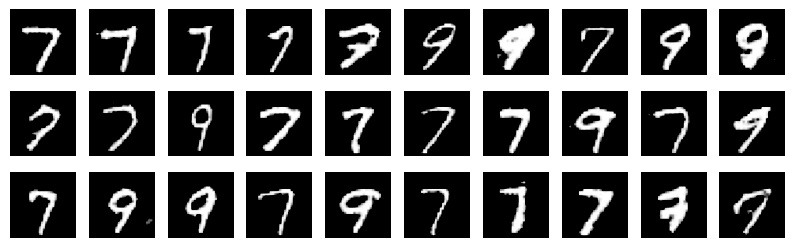

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 33 [0/60160]		D-Loss: 0.152326	G-Loss: 2.564870
Train | Epoch: 33 [12800/60160]		D-Loss: 0.175162	G-Loss: 2.535590
Train | Epoch: 33 [25600/60160]		D-Loss: 0.133654	G-Loss: 2.693030
Train | Epoch: 33 [38400/60160]		D-Loss: 0.187379	G-Loss: 3.345600
Train | Epoch: 33 [51200/60160]		D-Loss: 0.293233	G-Loss: 2.153986
====> Train | Epoch: 33 	 | 	Average D-loss: 0.2016 	 | 	Average G-loss: 3.1212
====> Test | Average D-loss: 0.2690 	 | 	Average G-loss: 3.0811
torch.Size([30, 1, 28, 28])


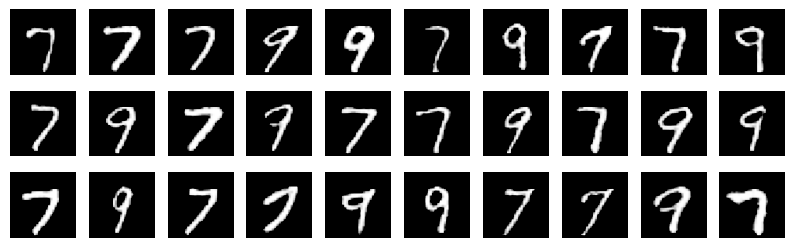

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 34 [0/60160]		D-Loss: 0.150128	G-Loss: 3.104053
Train | Epoch: 34 [12800/60160]		D-Loss: 0.163983	G-Loss: 3.596596
Train | Epoch: 34 [25600/60160]		D-Loss: 0.188713	G-Loss: 3.985593
Train | Epoch: 34 [38400/60160]		D-Loss: 0.203991	G-Loss: 2.851724
Train | Epoch: 34 [51200/60160]		D-Loss: 0.271348	G-Loss: 2.418865
====> Train | Epoch: 34 	 | 	Average D-loss: 0.2024 	 | 	Average G-loss: 3.0620


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6a

====> Test | Average D-loss: 0.2316 	 | 	Average G-loss: 3.1955
torch.Size([30, 1, 28, 28])


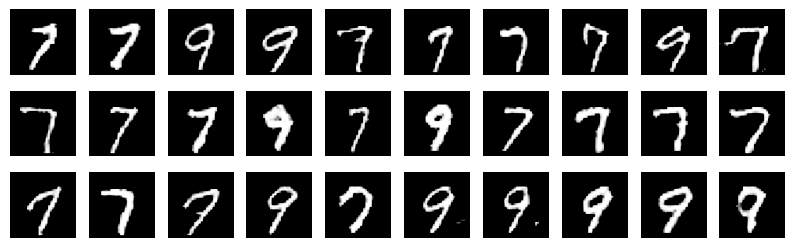

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 35 [0/60160]		D-Loss: 0.115254	G-Loss: 3.197622
Train | Epoch: 35 [12800/60160]		D-Loss: 0.181241	G-Loss: 2.473411
Train | Epoch: 35 [25600/60160]		D-Loss: 0.163269	G-Loss: 2.600737
Train | Epoch: 35 [38400/60160]		D-Loss: 0.234894	G-Loss: 3.383726
Train | Epoch: 35 [51200/60160]		D-Loss: 0.152842	G-Loss: 2.790282
====> Train | Epoch: 35 	 | 	Average D-loss: 0.1930 	 | 	Average G-loss: 3.1596
====> Test | Average D-loss: 0.2714 	 | 	Average G-loss: 2.3634
torch.Size([30, 1, 28, 28])


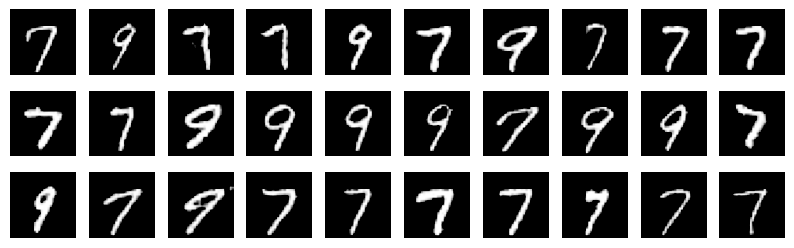

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 36 [0/60160]		D-Loss: 0.148276	G-Loss: 3.364606
Train | Epoch: 36 [12800/60160]		D-Loss: 0.328447	G-Loss: 3.106672
Train | Epoch: 36 [25600/60160]		D-Loss: 0.187314	G-Loss: 3.503499
Train | Epoch: 36 [38400/60160]		D-Loss: 0.180356	G-Loss: 3.091656
Train | Epoch: 36 [51200/60160]		D-Loss: 0.190458	G-Loss: 2.855321
====> Train | Epoch: 36 	 | 	Average D-loss: 0.1826 	 | 	Average G-loss: 3.2984
====> Test | Average D-loss: 0.1735 	 | 	Average G-loss: 3.4737
torch.Size([30, 1, 28, 28])


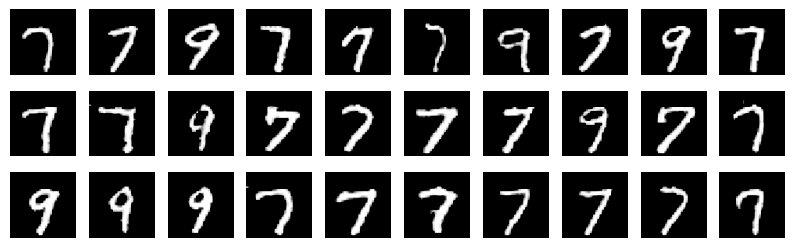

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 37 [0/60160]		D-Loss: 0.093227	G-Loss: 3.093385
Train | Epoch: 37 [12800/60160]		D-Loss: 0.201348	G-Loss: 3.570037
Train | Epoch: 37 [25600/60160]		D-Loss: 0.128776	G-Loss: 3.233084
Train | Epoch: 37 [38400/60160]		D-Loss: 0.157434	G-Loss: 3.825538
Train | Epoch: 37 [51200/60160]		D-Loss: 0.223943	G-Loss: 3.280082
====> Train | Epoch: 37 	 | 	Average D-loss: 0.1886 	 | 	Average G-loss: 3.3002
====> Test | Average D-loss: 0.2542 	 | 	Average G-loss: 4.2825
torch.Size([30, 1, 28, 28])


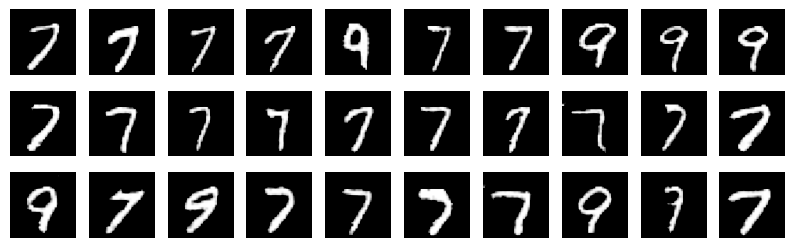

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 38 [0/60160]		D-Loss: 0.118311	G-Loss: 4.999671
Train | Epoch: 38 [12800/60160]		D-Loss: 0.180418	G-Loss: 2.841669
Train | Epoch: 38 [25600/60160]		D-Loss: 0.162523	G-Loss: 3.038773
Train | Epoch: 38 [38400/60160]		D-Loss: 0.240420	G-Loss: 3.102012
Train | Epoch: 38 [51200/60160]		D-Loss: 0.219876	G-Loss: 3.312574
====> Train | Epoch: 38 	 | 	Average D-loss: 0.1874 	 | 	Average G-loss: 3.3329
====> Test | Average D-loss: 0.3959 	 | 	Average G-loss: 4.4242
torch.Size([30, 1, 28, 28])


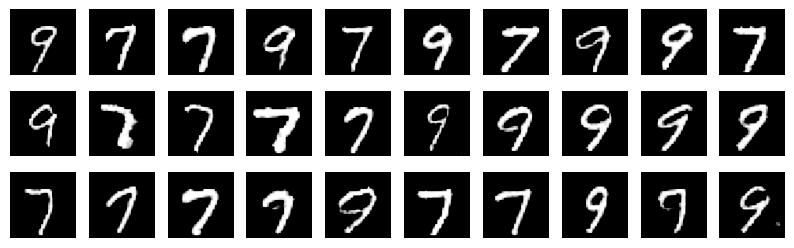

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 39 [0/60160]		D-Loss: 0.289628	G-Loss: 4.579587
Train | Epoch: 39 [12800/60160]		D-Loss: 0.094586	G-Loss: 4.369548
Train | Epoch: 39 [25600/60160]		D-Loss: 0.215767	G-Loss: 4.677764
Train | Epoch: 39 [38400/60160]		D-Loss: 0.095729	G-Loss: 3.971550
Train | Epoch: 39 [51200/60160]		D-Loss: 0.139114	G-Loss: 3.972415
====> Train | Epoch: 39 	 | 	Average D-loss: 0.1842 	 | 	Average G-loss: 3.5066
====> Test | Average D-loss: 0.3250 	 | 	Average G-loss: 3.8110
torch.Size([30, 1, 28, 28])


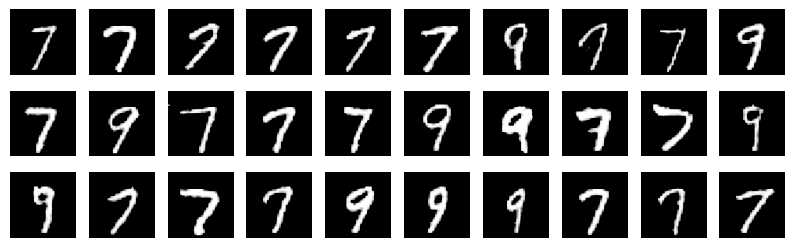

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 40 [0/60160]		D-Loss: 0.211936	G-Loss: 3.046491
Train | Epoch: 40 [12800/60160]		D-Loss: 0.210798	G-Loss: 3.071466
Train | Epoch: 40 [25600/60160]		D-Loss: 0.218145	G-Loss: 2.992615
Train | Epoch: 40 [38400/60160]		D-Loss: 0.198742	G-Loss: 3.056300
Train | Epoch: 40 [51200/60160]		D-Loss: 0.175008	G-Loss: 4.293462
====> Train | Epoch: 40 	 | 	Average D-loss: 0.1830 	 | 	Average G-loss: 3.2020
====> Test | Average D-loss: 0.2720 	 | 	Average G-loss: 3.2143
torch.Size([30, 1, 28, 28])


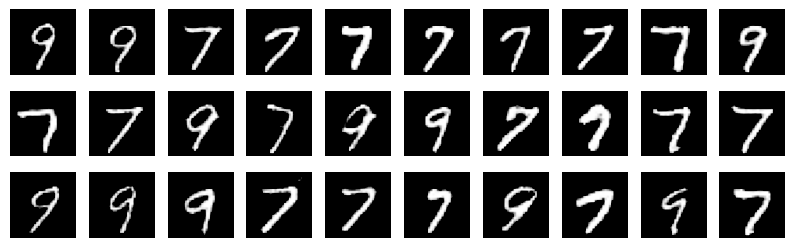

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 41 [0/60160]		D-Loss: 0.228578	G-Loss: 4.064701
Train | Epoch: 41 [12800/60160]		D-Loss: 0.109013	G-Loss: 3.225427
Train | Epoch: 41 [25600/60160]		D-Loss: 0.148521	G-Loss: 2.355644
Train | Epoch: 41 [38400/60160]		D-Loss: 0.156821	G-Loss: 4.550199
Train | Epoch: 41 [51200/60160]		D-Loss: 0.168024	G-Loss: 3.158945
====> Train | Epoch: 41 	 | 	Average D-loss: 0.1731 	 | 	Average G-loss: 3.3916
====> Test | Average D-loss: 0.2548 	 | 	Average G-loss: 3.2902
torch.Size([30, 1, 28, 28])


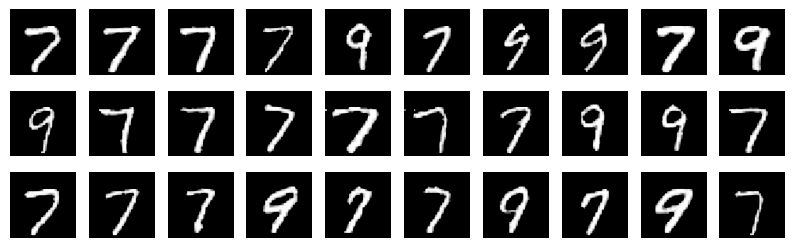

  0%|          | 0/235 [00:01<?, ?it/s]

Train | Epoch: 42 [0/60160]		D-Loss: 0.094017	G-Loss: 3.836734
Train | Epoch: 42 [12800/60160]		D-Loss: 0.133457	G-Loss: 2.807899
Train | Epoch: 42 [25600/60160]		D-Loss: 0.156477	G-Loss: 3.954870
Train | Epoch: 42 [38400/60160]		D-Loss: 0.134320	G-Loss: 2.651025
Train | Epoch: 42 [51200/60160]		D-Loss: 0.238881	G-Loss: 3.748447
====> Train | Epoch: 42 	 | 	Average D-loss: 0.1687 	 | 	Average G-loss: 3.4330
====> Test | Average D-loss: 0.2714 	 | 	Average G-loss: 2.6116
torch.Size([30, 1, 28, 28])


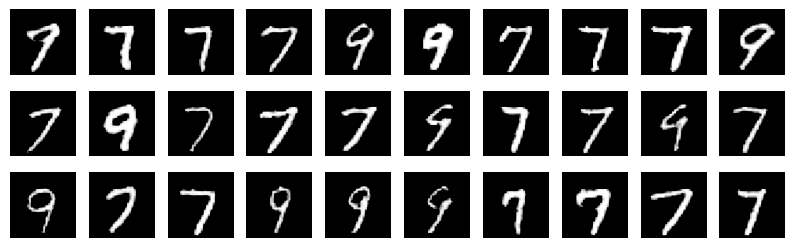

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 43 [0/60160]		D-Loss: 0.257495	G-Loss: 4.054952
Train | Epoch: 43 [12800/60160]		D-Loss: 0.147640	G-Loss: 3.349844
Train | Epoch: 43 [25600/60160]		D-Loss: 0.139250	G-Loss: 3.381249
Train | Epoch: 43 [38400/60160]		D-Loss: 0.138739	G-Loss: 4.290570
Train | Epoch: 43 [51200/60160]		D-Loss: 0.211910	G-Loss: 4.043594
====> Train | Epoch: 43 	 | 	Average D-loss: 0.1570 	 | 	Average G-loss: 3.5545
====> Test | Average D-loss: 0.2967 	 | 	Average G-loss: 2.9899
torch.Size([30, 1, 28, 28])


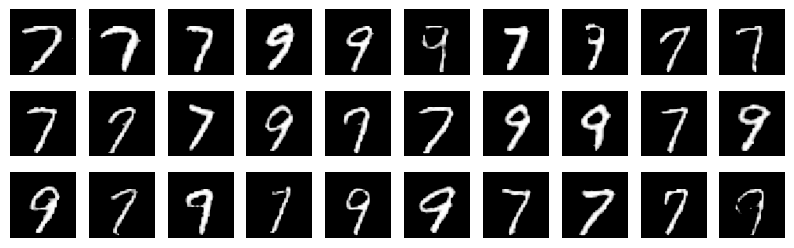

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 44 [0/60160]		D-Loss: 0.226357	G-Loss: 3.841489
Train | Epoch: 44 [12800/60160]		D-Loss: 0.171113	G-Loss: 3.652667
Train | Epoch: 44 [25600/60160]		D-Loss: 0.130207	G-Loss: 2.959421
Train | Epoch: 44 [38400/60160]		D-Loss: 0.236577	G-Loss: 4.588974
Train | Epoch: 44 [51200/60160]		D-Loss: 0.114752	G-Loss: 4.448126
====> Train | Epoch: 44 	 | 	Average D-loss: 0.1553 	 | 	Average G-loss: 3.6339
====> Test | Average D-loss: 0.2403 	 | 	Average G-loss: 3.1149
torch.Size([30, 1, 28, 28])


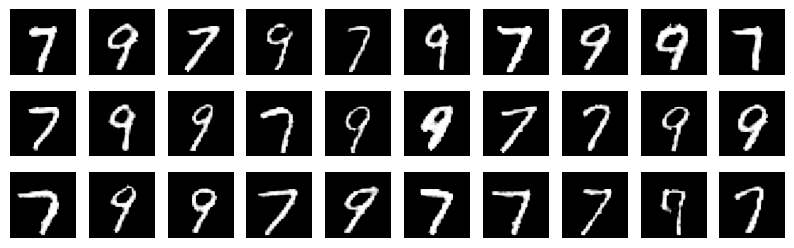

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 45 [0/60160]		D-Loss: 0.168658	G-Loss: 3.380687
Train | Epoch: 45 [12800/60160]		D-Loss: 0.108549	G-Loss: 3.144867
Train | Epoch: 45 [25600/60160]		D-Loss: 0.212109	G-Loss: 3.759355
Train | Epoch: 45 [38400/60160]		D-Loss: 0.141458	G-Loss: 4.027195
Train | Epoch: 45 [51200/60160]		D-Loss: 0.119994	G-Loss: 4.356855
====> Train | Epoch: 45 	 | 	Average D-loss: 0.1538 	 | 	Average G-loss: 3.6467


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc2384c0>  File "/usr/lib/python3.10/multiprocessing/process.py", lin

====> Test | Average D-loss: 0.2882 	 | 	Average G-loss: 3.5573
torch.Size([30, 1, 28, 28])


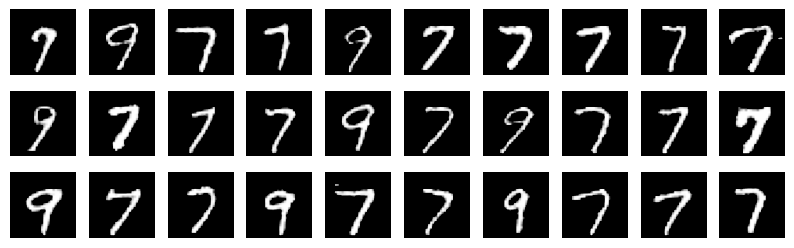

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 46 [0/60160]		D-Loss: 0.105599	G-Loss: 3.429229
Train | Epoch: 46 [12800/60160]		D-Loss: 0.123896	G-Loss: 4.430598
Train | Epoch: 46 [25600/60160]		D-Loss: 0.149871	G-Loss: 3.184004
Train | Epoch: 46 [38400/60160]		D-Loss: 0.121193	G-Loss: 4.589405
Train | Epoch: 46 [51200/60160]		D-Loss: 0.202709	G-Loss: 3.557405
====> Train | Epoch: 46 	 | 	Average D-loss: 0.1438 	 | 	Average G-loss: 3.8127
====> Test | Average D-loss: 0.2510 	 | 	Average G-loss: 2.8861
torch.Size([30, 1, 28, 28])


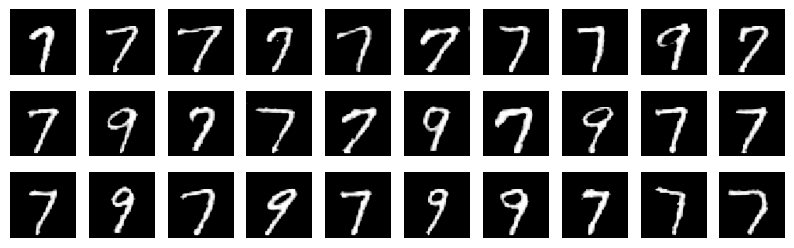

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 47 [0/60160]		D-Loss: 0.137778	G-Loss: 3.395204
Train | Epoch: 47 [12800/60160]		D-Loss: 0.165948	G-Loss: 4.369486
Train | Epoch: 47 [25600/60160]		D-Loss: 0.188456	G-Loss: 3.771424
Train | Epoch: 47 [38400/60160]		D-Loss: 0.118213	G-Loss: 2.799035
Train | Epoch: 47 [51200/60160]		D-Loss: 0.103046	G-Loss: 4.200692
====> Train | Epoch: 47 	 | 	Average D-loss: 0.1429 	 | 	Average G-loss: 3.8420
====> Test | Average D-loss: 0.2402 	 | 	Average G-loss: 3.6567
torch.Size([30, 1, 28, 28])


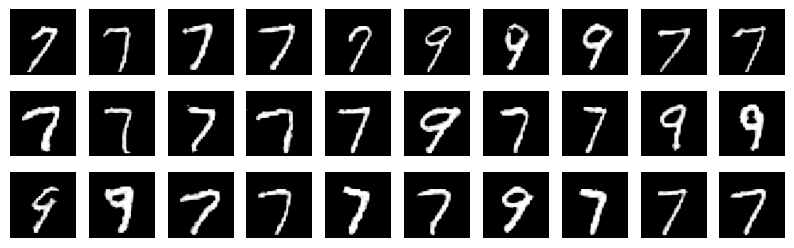

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 48 [0/60160]		D-Loss: 0.134826	G-Loss: 3.235137
Train | Epoch: 48 [12800/60160]		D-Loss: 0.107618	G-Loss: 4.015372
Train | Epoch: 48 [25600/60160]		D-Loss: 0.220952	G-Loss: 4.880274
Train | Epoch: 48 [38400/60160]		D-Loss: 0.128879	G-Loss: 4.515244
Train | Epoch: 48 [51200/60160]		D-Loss: 0.123315	G-Loss: 3.575150
====> Train | Epoch: 48 	 | 	Average D-loss: 0.1314 	 | 	Average G-loss: 3.9314
====> Test | Average D-loss: 0.2599 	 | 	Average G-loss: 3.4293
torch.Size([30, 1, 28, 28])


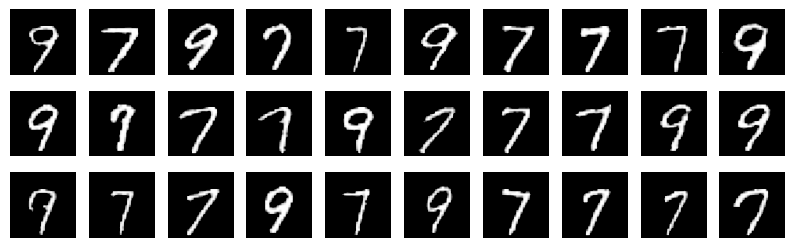

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 49 [0/60160]		D-Loss: 0.090240	G-Loss: 3.721619
Train | Epoch: 49 [12800/60160]		D-Loss: 0.176765	G-Loss: 4.621799
Train | Epoch: 49 [25600/60160]		D-Loss: 0.080103	G-Loss: 3.489547
Train | Epoch: 49 [38400/60160]		D-Loss: 0.151965	G-Loss: 5.104089
Train | Epoch: 49 [51200/60160]		D-Loss: 0.094584	G-Loss: 3.614512
====> Train | Epoch: 49 	 | 	Average D-loss: 0.1120 	 | 	Average G-loss: 4.2764
====> Test | Average D-loss: 0.2597 	 | 	Average G-loss: 3.4493
torch.Size([30, 1, 28, 28])


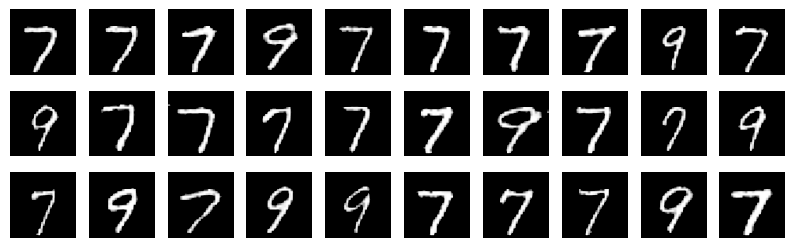

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 50 [0/60160]		D-Loss: 0.118693	G-Loss: 4.527710
Train | Epoch: 50 [12800/60160]		D-Loss: 0.087839	G-Loss: 5.476696
Train | Epoch: 50 [25600/60160]		D-Loss: 0.169285	G-Loss: 4.450235
Train | Epoch: 50 [38400/60160]		D-Loss: 0.147983	G-Loss: 4.836674
Train | Epoch: 50 [51200/60160]		D-Loss: 0.139641	G-Loss: 3.479274
====> Train | Epoch: 50 	 | 	Average D-loss: 0.1243 	 | 	Average G-loss: 4.1396
====> Test | Average D-loss: 0.3105 	 | 	Average G-loss: 4.5514
torch.Size([30, 1, 28, 28])


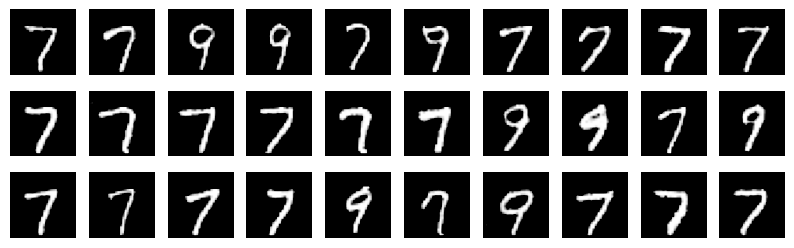

In [ ]:

mnist_trainer.run(n_epoch= 50, G_update_times=1, D_update_times=1, verbose=True)


### 4.4.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 16 to 19)

torch.Size([30, 1, 28, 28])


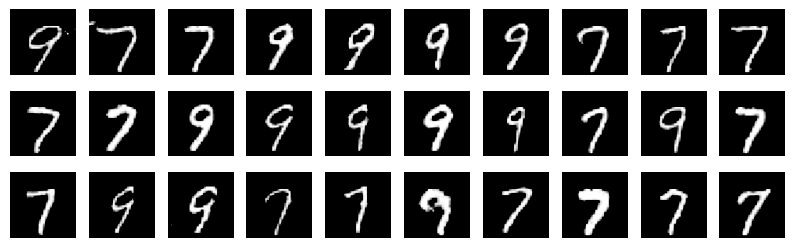

In [ ]:
mnist_visulization_helper_fn(mnist_trainer)